# Deploy the model below

In [32]:
!pip install -q boto3
!pip install -q xgboost==0.90

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
tensorflow 2.0.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.3 which is incompatible.
awscli 1.18.20 has requirement botocore==1.15.20, but you'll have botocore 1.15.23 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
tensorflow 2.0.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.3 which is incompatible.
awscli 1.18.20 has requirement botocore==1.15.20, but you'll have botocore 1.15.23 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading v

In [33]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [34]:
%store -r spark_processing_job_s3_output_prefix

In [35]:
print('Previous Spark Processing Job Name: {}'.format(spark_processing_job_s3_output_prefix))

Previous Spark Processing Job Name: amazon-reviews-spark-processor-2020-03-20-05-37-14


# Specify the S3 Location of the Features

In [7]:

# TODO:  Add `/output/` and remove `-csv` once the new spark job is done!


prefix_train = '{}/tfidf-labeled-split-balanced-noheader-train'.format(spark_processing_job_s3_output_prefix)
prefix_validation = '{}/tfidf-labeled-split-balanced-noheader-validation'.format(spark_processing_job_s3_output_prefix)
prefix_test = '{}/tfidf-labeled-split-balanced-noheader-test'.format(spark_processing_job_s3_output_prefix)

balanced_tfidf_without_header_train_path = './{}'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}'.format(prefix_test)

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

s3_input_train_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_train_s3_uri, content_type='text/csv')
s3_input_validation_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_validation_s3_uri, content_type='text/csv')
s3_input_test_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_test_s3_uri, content_type='text/csv')

print(s3_input_train_data.config)
print(s3_input_validation_data.config)
print(s3_input_test_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-train', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-validation', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}


In [10]:
from sagemaker.amazon.amazon_estimator import get_image_uri 
import json

# get the URI for new container
builtin_container_uri = get_image_uri(region_name=region,                                
                                      repo_name='xgboost', 
                                      repo_version='0.90-2')
print(builtin_container_uri)

model_output_path = 's3://{}/models/built-in/training-runs'.format(bucket)
print(model_output_path)

xgb_estimator = sagemaker.estimator.Estimator(image_name=builtin_container_uri, 
                                              role=role, 
                                              train_instance_count=3,
                                              train_instance_type='ml.c5.4xlarge',
                                              output_path=model_output_path, 
                                              sagemaker_session=sess,
                                              # enable_cloudwatch_metrics=True
                                             )

xgb_estimator.set_hyperparameters(objective='binary:logistic',
                                  num_round=1,
                                  max_depth=5)


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3
s3://sagemaker-us-east-1-835319576252/models/built-in/training-runs


In [11]:
xgb_estimator.fit({'train': s3_input_train_data,
                   'validation': s3_input_validation_data
                  }
                  #, wait=False
                 )

2020-03-20 06:12:11 Starting - Starting the training job...
2020-03-20 06:12:12 Starting - Launching requested ML instances......
2020-03-20 06:13:18 Starting - Preparing the instances for training...
2020-03-20 06:14:10 Downloading - Downloading input data............
2020-03-20 06:15:57 Training - Downloading the training image.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is 

INFO:RabitTracker:[0]#011train-error:0.329775#011validation-error:0.461375
INFO:RabitTracker:@tracker All nodes finishes job
INFO:RabitTracker:@tracker 25.407633066177368 secs between node start and job finish

2020-03-20 06:18:35 Uploading - Uploading generated training model
2020-03-20 06:18:35 Completed - Training job completed
Training seconds: 795
Billable seconds: 795


In [15]:
training_job_name = xgb_estimator.latest_training_job.name
print('training_job_name:  {}'.format(training_job_name))

training_job_name:  sagemaker-xgboost-2020-03-20-06-12-11-407


In [16]:
# TODO:  This isn't working at the moment
#from sagemaker.xgboost import XGBoost

#xgb_estimator = XGBoost.attach(training_job_name=training_job_name)

# Load the Model

In [36]:
# download the model artifact from AWS S3
!aws s3 cp $model_output_path/$training_job_name/output/model.tar.gz ./models/built-in/

download: s3://sagemaker-us-east-1-835319576252/models/built-in/training-runs/sagemaker-xgboost-2020-03-20-06-12-11-407/output/model.tar.gz to models/built-in/model.tar.gz


In [37]:
import tarfile
import pickle as pkl

tar = tarfile.open('./models/built-in/model.tar.gz')
tar.extractall(path='./models/built-in/')
tar.close()

In [38]:
!ls -al ./models/built-in/

total 20
drwxrwxr-x 2 ec2-user ec2-user 4096 Mar 20 06:29 .
drwxrwxr-x 3 ec2-user ec2-user 4096 Mar 20 06:19 ..
-rw-rw-r-- 1 ec2-user ec2-user 2804 Mar 20 06:18 model.tar.gz
-rw-r--r-- 1 ec2-user ec2-user 6326 Mar 20 06:18 xgboost-model


In [41]:
import pickle as pkl

model_dir = './models/built-in'
model_path = os.path.join(model_dir, 'xgboost-model')

xgb_estimator_restored = pkl.load(open(model_path, 'rb'))

type(xgb_estimator_restored)


xgboost.core.Booster

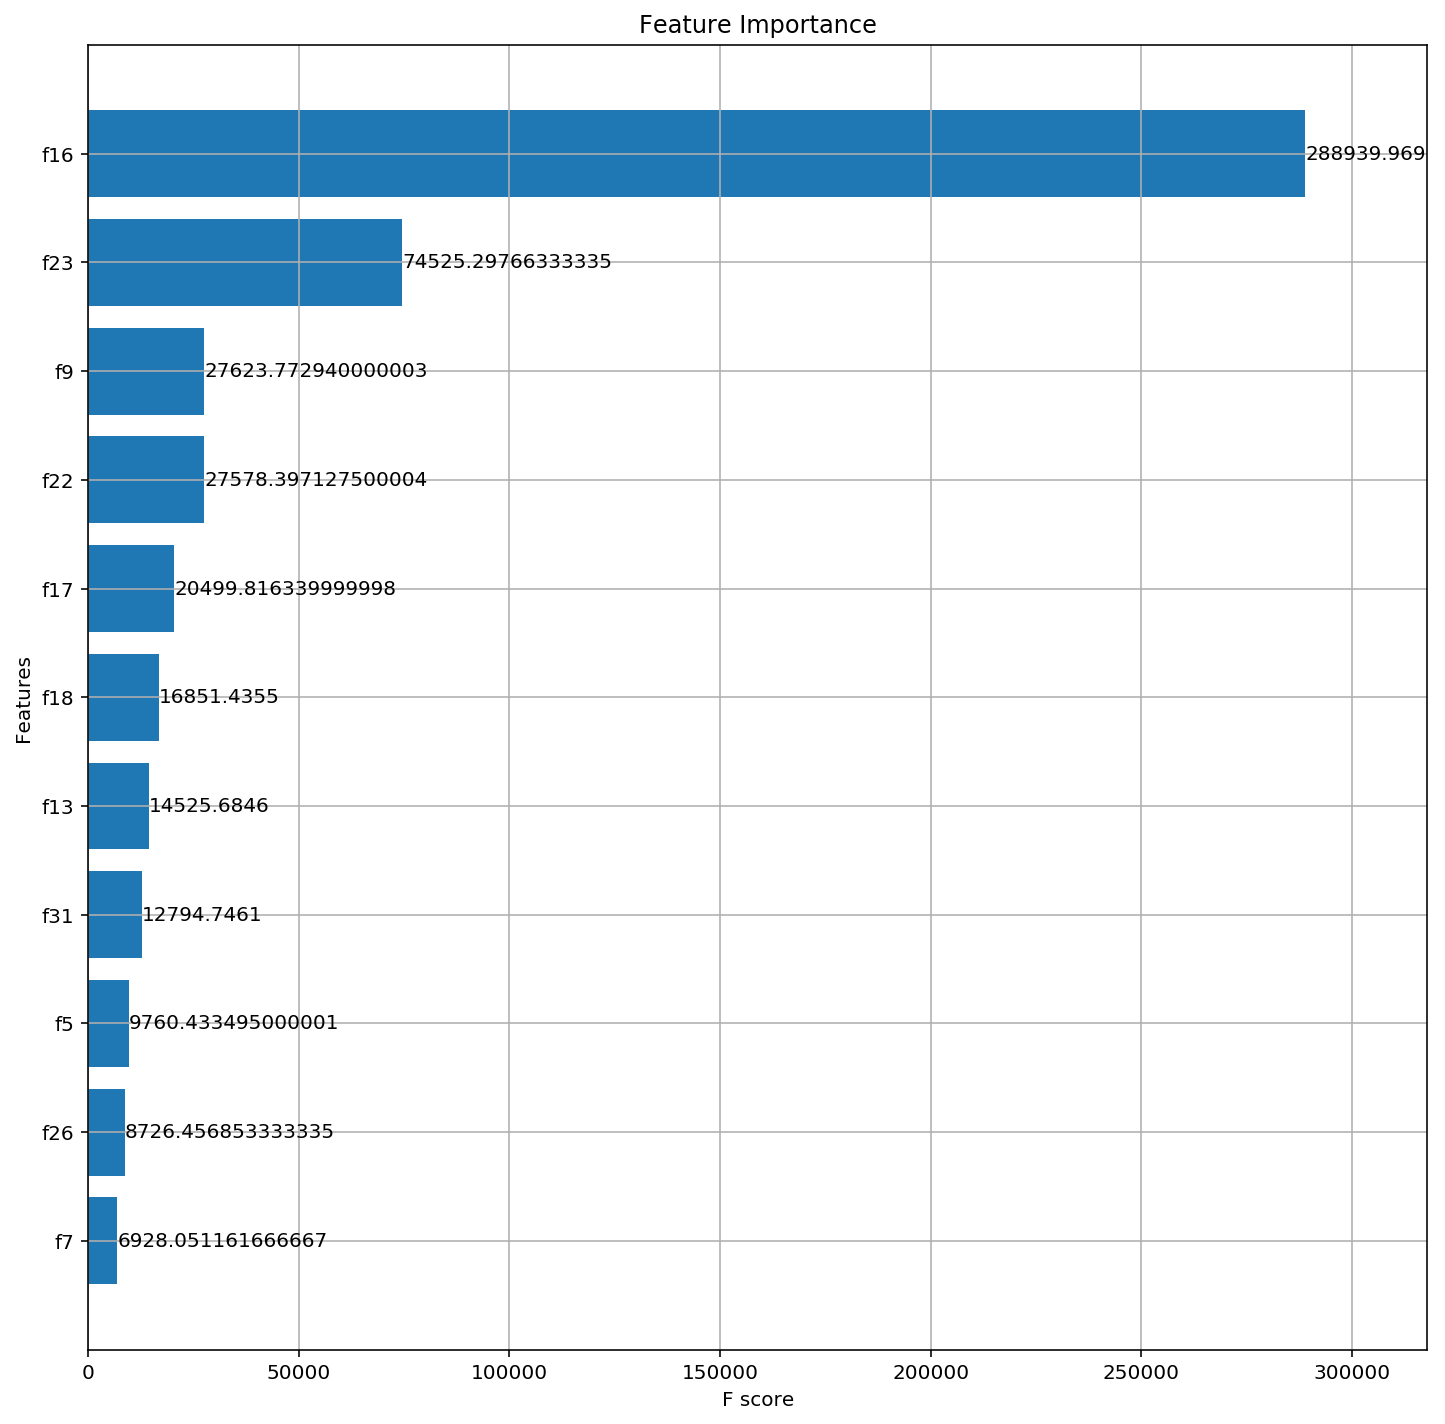

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(xgb_estimator_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

#  Calculate Test Metrics

## Download Test Dataset and Load into Memory

In [43]:


# TODO:  Add `/output/` and remove `-csv` once the new spark job is done!


import os
os.makedirs(prefix_test, exist_ok=True)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)
balanced_tfidf_without_header_test_path = './{}'.format(prefix_test)

print(balanced_tfidf_without_header_test_s3_uri)
print(balanced_tfidf_without_header_test_path)

s3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test
./amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test


In [44]:
!aws s3 ls --recursive $balanced_tfidf_without_header_test_s3_uri

2020-03-20 05:46:35          0 amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/_SUCCESS
2020-03-20 05:46:29  194970103 amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00000-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv
2020-03-20 05:46:31  195048316 amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00001-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv
2020-03-20 05:46:26  113304252 amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00002-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv
2020-03-20 05:46:26   81063264 amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00003-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv
2020-03-20 05:46:24   49307223 amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00004-9b

In [45]:
!aws s3 cp --recursive $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/_SUCCESS to amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/_SUCCESS
download: s3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00004-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv to amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00004-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv
download: s3://sagemaker-us-east-1-835319576252/amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00003-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv to amazon-reviews-spark-processor-2020-03-20-05-37-14/tfidf-labeled-split-balanced-noheader-test/part-00003-9b76930f-849b-464a-ac0a-668bbcec3c78-c000.csv
download: s3://sagemaker-us-east-1-83

In [46]:
import glob
import pandas as pd

def load_dataset(path, sep, header):
    data = pd.concat([pd.read_csv(f, sep=sep, header=header) for f in glob.glob('{}/*.csv'.format(path))], ignore_index = True)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [47]:
X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)
X_test.shape

(106308, 300)

In [48]:
X_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.219203,0.229410,-0.682858,0.212615,-0.567484,-0.319378,-0.468095,0.237631,0.199338,0.199203,...,-0.258840,0.540230,0.025357,0.553437,-0.965112,0.291190,-0.915715,-0.225527,-0.406609,0.623166
1,-0.194890,0.098241,0.207867,0.047665,-0.058328,-0.026513,-0.279147,0.247797,-0.285165,0.146645,...,0.549893,0.181362,-0.450457,0.137160,-0.673670,-0.207617,-0.479012,1.021196,-0.300345,-0.394296
2,-0.698950,-1.018251,0.271470,1.181818,0.222836,-0.763486,1.038242,-0.755143,0.457346,-1.314663,...,0.079621,0.023388,0.047515,0.675150,1.072506,-0.244371,-0.351074,-0.216352,-0.993339,0.248929
3,-0.406105,-0.177591,-0.049656,0.337567,-0.357547,-0.015926,0.760039,0.081938,-0.420287,-0.487599,...,-0.436221,-0.236772,-0.410540,-0.841615,0.110480,0.492008,-0.183220,-1.102833,0.072397,-0.390112
4,-0.016527,0.016471,-0.040318,0.069327,0.007348,-0.078842,0.174127,-0.152050,0.132375,-0.343449,...,-0.010752,0.012295,0.011011,0.040464,0.115901,0.133367,0.135950,0.061208,-0.035668,0.025023


In [49]:
from xgboost import DMatrix

# Must convert pandas dataframe to XGBoost DMatrix before predicting
preds_test = xgb_estimator_restored.predict(DMatrix(X_test))
preds_test.shape

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299'] ['0  ', '1  ', '2  ', '3  ', '4  ', '5  ', '6  ', '7  ', '8  ', '9  ', '10 ', '11 ', '12 ', '13 ', '14 ', '15 ', '16 ', '17 ', '18 ', '19 ', '20 ', '21 ', '22 ', '23 ', '24 ', '25 ', '26 ', '27 ', '28 ', '29 ', '30 ', '31 ', '32 ', '33 ', '34 ', '35 ', '36 ', '37 ', '38 ', '39 ', '40 ', '41 ', '42 ', '43 ', '44 ', '45 ', '46 ', '47 ', '48 ', '49 ', '50 ', '51 ', '52 ', '53 ', '54 ', '55 ', '56 ', '57 ', '58 ', '59 ', '60 ', '61 ', '62 ', '63 ', '64 ', '65 ', '66 ', '67 ', '68 ', '69 ', '70 ', '71 ', '72 ', '73 ', '74 ', '75 ', '76 ', '77 ', '78 ', '79 ', '80 ', '81 ', '82 ', '83 ', '84 ', '85 ', '86 ', '87 ', '88 ', '89 ', '90 ', '91 ', '92 ', '93 ', '94 ', '95 ', '96 ', '97 ', '98 ', '99 ', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299']
expected f175, f120, f20, f80, f167, f287, f291, f238, f31, f262, f266, f29, f154, f4, f268, f1, f183, f168, f285, f35, f79, f100, f89, f111, f26, f220, f146, f12, f39, f117, f274, f288, f140, f90, f230, f75, f122, f293, f36, f98, f55, f91, f38, f294, f3, f131, f193, f83, f152, f94, f254, f15, f259, f296, f72, f13, f6, f206, f200, f203, f46, f115, f107, f165, f37, f169, f202, f228, f18, f273, f244, f145, f102, f177, f81, f149, f0, f40, f280, f201, f69, f271, f95, f256, f11, f33, f163, f87, f142, f71, f7, f226, f209, f267, f281, f249, f162, f185, f85, f9, f78, f170, f180, f139, f65, f214, f62, f218, f236, f113, f133, f243, f283, f84, f76, f157, f232, f24, f48, f241, f208, f263, f292, f189, f148, f182, f118, f144, f219, f104, f99, f141, f194, f224, f297, f101, f82, f123, f129, f155, f187, f41, f188, f23, f96, f251, f190, f295, f19, f255, f284, f58, f45, f121, f248, f114, f66, f277, f147, f50, f125, f205, f261, f258, f217, f264, f269, f42, f164, f290, f88, f110, f32, f138, f235, f237, f286, f178, f25, f56, f179, f222, f130, f17, f47, f159, f174, f250, f21, f93, f227, f51, f70, f106, f173, f282, f143, f105, f197, f135, f60, f134, f229, f186, f14, f247, f275, f77, f260, f10, f171, f231, f112, f53, f30, f156, f34, f215, f27, f158, f2, f239, f49, f44, f28, f132, f153, f245, f298, f289, f67, f225, f63, f16, f68, f207, f150, f151, f124, f196, f108, f52, f195, f54, f5, f176, f74, f184, f199, f126, f242, f43, f22, f136, f137, f61, f192, f240, f73, f103, f64, f86, f59, f57, f210, f221, f265, f172, f128, f270, f223, f276, f119, f233, f257, f166, f234, f252, f109, f160, f92, f198, f97, f212, f299, f181, f204, f279, f127, f161, f8, f116, f191, f253, f213, f272, f216, f246, f211, f278 in input data
training data did not have the following fields: 231, 137, 27 , 46 , 117, 127, 196, 156, 299, 191, 108, 175, 66 , 192, 205, 235, 267, 131, 57 , 3  , 222, 265, 261, 135, 272, 168, 207, 246, 74 , 155, 73 , 25 , 208, 240, 54 , 154, 44 , 86 , 56 , 124, 15 , 218, 293, 184, 70 , 237, 71 , 116, 204, 143, 262, 122, 51 , 91 , 193, 138, 214, 249, 99 , 130, 126, 223, 273, 18 , 148, 210, 198, 268, 125, 297, 136, 48 , 185, 60 , 181, 186, 195, 260, 31 , 233, 67 , 100, 65 , 146, 24 , 159, 150, 212, 32 , 236, 12 , 107, 13 , 16 , 77 , 69 , 141, 152, 298, 63 , 88 , 144, 224, 289, 22 , 269, 241, 11 , 98 , 216, 95 , 118, 103, 170, 202, 234, 280, 9  , 96 , 255, 288, 200, 17 , 114, 221, 110, 10 , 294, 45 , 89 , 147, 162, 271, 264, 270, 277, 83 , 104, 230, 178, 123, 206, 38 , 239, 259, 189, 225, 84 , 105, 256, 160, 238, 6  , 266, 93 , 187, 242, 286, 197, 59 , 199, 174, 20 , 129, 285, 165, 253, 295, 113, 250, 296, 0  , 258, 149, 41 , 62 , 161, 94 , 111, 215, 254, 52 , 85 , 97 , 68 , 133, 5  , 78 , 180, 140, 183, 109, 50 , 42 , 211, 232, 257, 167, 53 , 245, 58 , 177, 64 , 229, 157, 171, 47 , 213, 134, 35 , 101, 39 , 151, 217, 33 , 90 , 128, 282, 121, 23 , 251, 281, 40 , 139, 153, 43 , 284, 49 , 290, 158, 163, 283, 227, 75 , 14 , 173, 7  , 228, 29 , 76 , 36 , 142, 201, 112, 4  , 26 , 279, 115, 276, 244, 120, 30 , 164, 248, 203, 102, 2  , 21 , 79 , 145, 226, 275, 287, 252, 28 , 182, 169, 1  , 106, 92 , 291, 194, 278, 72 , 119, 87 , 80 , 166, 247, 37 , 132, 188, 292, 34 , 209, 220, 61 , 55 , 172, 81 , 176, 179, 219, 263, 8  , 82 , 190, 19 , 274, 243

### Convert probability values into classification (0 or 1) using threshold 0.5

In [ ]:
import numpy as np
preds_test_0_or_1 = np.where(preds_test > 0.5, 1, 0)
preds_test_0_or_1.shape

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test_0_or_1))
print('Test Precision: ', precision_score(y_test, preds_test_0_or_1, average=None))

In [ ]:
print(classification_report(y_test, preds_test_0_or_1))

In [ ]:
df_cm_test = confusion_matrix(y_test, preds_test_0_or_1)
df_cm_test

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Hyper Parameter Tuning

In [ ]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:auc'

tuner_log = HyperparameterTuner(
    xgb_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=10,
    strategy='Bayesian'
)

## Start the hyperparameter tuning job

In [ ]:
tuner_log.fit({'train': balanced_tfidf_without_header_train_s3_uri, 
               'validation': balanced_tfidf_without_header_validation_s3_uri}, 
               include_cls_metadata=False)

In [ ]:
## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']


# Deploy Endpoint

### From an external application, you can use the following code to make a prediction

In [ ]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [ ]:
import time

# https://towardsdatascience.com/xgboost-in-amazon-sagemaker-28e5e354dbcd
from sagemaker.predictor import csv_serializer

xgb_endpoint_name = 'xgboost-built-in-{}'.format(time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()))
xgb_endpoint_name

In [ ]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb_estimator.deploy(initial_instance_count = 1, 
                                     instance_type = 'ml.m4.xlarge',
                                     endpoint_name=xgb_endpoint_name)

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

sm_runtime = boto3.client('sagemaker-runtime')

payload_500_samples = X_test[:500].to_csv(index=False, header=False).rstrip()

response_500_samples = sm_runtime.invoke_endpoint(
    EndpointName=xgb_endpoint_name,
    Body=payload.encode('utf-8'),
    ContentType='text/csv')['Body'].read()

In [ ]:
predictions_500_samples = np.fromstring(response_500_samples, sep=',')
predictions_500_samples_0_or_1 = np.where(predictions_500_samples > 0.5, 1, 0)

In [ ]:
print('Test Accuracy: ', accuracy_score(y_test[:500], predictions_500_samples_0_or_1))
print('Test Precision: ', precision_score(y_test[:500], predictions_500_samples_0_or_1, average=None))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test[:500], predictions_500_samples_0_or_1)
df_cm_test

In [ ]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# TODO:  XGBoostPredictor

In [ ]:
# TODO:  1) update this to do TF/IDF
#        2) use this in other versions of the model
# Derived from the following:
#   https://aim357.readthedocs.io/en/latest/GluePySparkMLFeatureEngineering/GluePySparkMLFeatureEngineering.html#deepar-deep-dive

class XGBoostPredictor(sagemaker.predictor.RealTimePredictor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)

    def predict(self, ts, cat=None, dynamic_feat=None,
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }

        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }

        return json.dumps(http_request_data).encode('utf-8')

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [ ]:
xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

xgb_predictor = xgb_estimator.deploy(
                     initial_instance_count=1, 
                     instance_type='ml.m4.xlarge',
                     predictor_cls=XGBoostPredictor,
                     endpoint_name=xgb_endpoint_name)

In [ ]:
predictions, raw_outputs = model.predict(["""Very funny. A typical mid 50's comedy."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))

In [ ]:
predictions, raw_outputs = bert_model.predict(["""That movie was absolutely awful."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))